In [2]:
import os
os.makedirs("data/raw", exist_ok=True)
os.makedirs("data/processed", exist_ok=True)

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

num_orders = 200000

orders = pd.DataFrame({
    "order_id": range(1, num_orders + 1),
    "customer_id": np.random.randint(1, 50001, num_orders),
    "product_id": np.random.randint(1, 5001, num_orders),
    "order_date": pd.to_datetime("2022-01-01") +
                  pd.to_timedelta(np.random.randint(0, 730, num_orders), unit="D"),
    "quantity": np.random.randint(1, 5, num_orders),
    "discount": np.round(np.random.uniform(0, 0.5, num_orders), 2),
    "order_status": np.random.choice(
        ["Delivered", "Cancelled", "Returned"],
        p=[0.85, 0.1, 0.05],
        size=num_orders
    )
})

orders.to_csv("data/raw/orders.csv", index=False)

In [4]:
orders["order_date"] = pd.to_datetime(orders["order_date"])
orders = orders.drop_duplicates()

orders = orders[
    (orders["quantity"] > 0) &
    (orders["discount"] >= 0) &
    (orders["discount"] <= 0.5)
]

orders.to_csv("data/processed/orders_cleaned.csv", index=False)

In [5]:
orders = pd.read_csv("data/processed/orders_cleaned.csv")
orders["order_date"] = pd.to_datetime(orders["order_date"])

In [6]:
orders = orders.sort_values(by=["customer_id", "order_date"])

In [7]:
customer_features = orders.groupby("customer_id").agg(
    total_orders=("order_id", "count"),
    total_quantity=("quantity", "sum"),
    avg_discount=("discount", "mean")
).reset_index()

In [8]:
delivered = orders[orders["order_status"] == "Delivered"]

success_rate = (
    delivered.groupby("customer_id").size()
    / orders.groupby("customer_id").size()
).fillna(0)

customer_features["success_rate"] = customer_features["customer_id"].map(success_rate)

In [9]:
orders["prev_order_date"] = orders.groupby("customer_id")["order_date"].shift(1)
orders["order_gap"] = (orders["order_date"] - orders["prev_order_date"]).dt.days

avg_gap = orders.groupby("customer_id")["order_gap"].mean().fillna(0)
last_order = orders.groupby("customer_id")["order_date"].max()

customer_features["avg_order_gap"] = customer_features["customer_id"].map(avg_gap)
customer_features["last_order_days"] = (
    pd.Timestamp("2024-01-01") - customer_features["customer_id"].map(last_order)
).dt.days

In [10]:
customer_features.to_csv("data/processed/customer_features.csv", index=False)
customer_features.head()

,customer_id,total_orders,total_quantity,avg_discount,success_rate,avg_order_gap,last_order_days
0,1,2,5,0.080000,1.000000,695.0,3
1,2,7,18,0.274286,0.571429,112.0,4
2,3,6,19,0.220000,0.833333,139.0,2
3,4,6,11,0.168333,1.000000,132.6,58
4,5,2,5,0.255000,1.000000,77.0,549


In [11]:
from sklearn.preprocessing import StandardScaler

features = customer_features[
    ["total_orders", "total_quantity", "avg_discount",
     "success_rate", "avg_order_gap", "last_order_days"]
]

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
from sklearn.cluster import KMeans

inertia = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

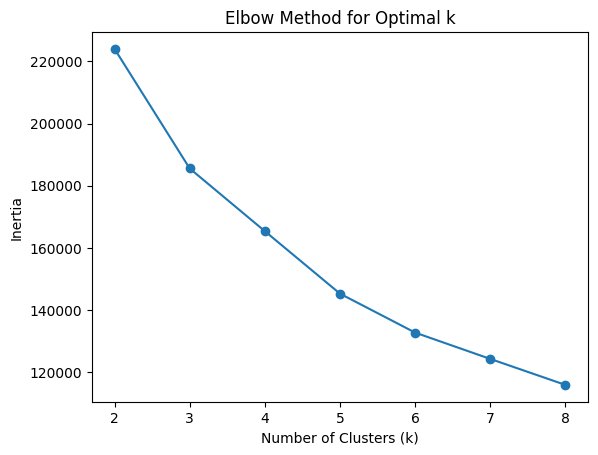

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(2, 9), inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features["segment"] = kmeans.fit_predict(scaled_features)

In [16]:
segment_profile = customer_features.groupby("segment").mean()
segment_profile

,customer_id,total_orders,total_quantity,avg_discount,success_rate,avg_order_gap,last_order_days
segment,,,,,,,
0,24981.715511,2.430553,5.928449,0.254595,0.863653,343.915199,126.144973
1,25000.650089,4.000941,9.739908,0.246093,0.839550,142.977005,119.825068
2,24951.937479,6.673519,17.402876,0.252082,0.854009,96.413207,98.600508
3,25075.510747,2.127609,5.144014,0.253357,0.856034,63.540006,395.766691


In [17]:
customer_features["clv_proxy"] = (
    customer_features["total_quantity"] *
    (1 - customer_features["avg_discount"])
)

In [18]:
X = customer_features[
    ["total_orders", "avg_discount",
     "success_rate", "avg_order_gap", "last_order_days"]
]

y = customer_features["clv_proxy"]

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(2.9897746465680006, 0.8168485311398219)

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [23]:
rf_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

rf_mse, rf_r2

(3.199326415112953, 0.804011538808205)

In [24]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance

,0
total_orders,0.794359
avg_discount,0.071194
avg_order_gap,0.061684
last_order_days,0.060986
success_rate,0.011778


In [25]:
customer_features["churn"] = (customer_features["last_order_days"] > 180).astype(int)

In [26]:
customer_features["churn"].value_counts(normalize=True)

,proportion
churn,
0,0.636279
1,0.363721


In [27]:
X = customer_features[
    ["total_orders", "avg_discount",
     "success_rate", "avg_order_gap", "last_order_days"]
]

y = customer_features["churn"]

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6251    0]
 [   0 3573]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6251
           1       1.00      1.00      1.00      3573

    accuracy                           1.00      9824
   macro avg       1.00      1.00      1.00      9824
weighted avg       1.00      1.00      1.00      9824



In [31]:
X = customer_features[
    ["total_orders", "avg_discount",
     "success_rate", "avg_order_gap"]
]

y = customer_features["churn"]

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = log_reg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5668  583]
 [1990 1583]]
              precision    recall  f1-score   support

           0       0.74      0.91      0.82      6251
           1       0.73      0.44      0.55      3573

    accuracy                           0.74      9824
   macro avg       0.74      0.67      0.68      9824
weighted avg       0.74      0.74      0.72      9824



In [35]:
log_reg_balanced = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

log_reg_balanced.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [36]:
y_pred_bal = log_reg_balanced.predict(X_test)

print(confusion_matrix(y_test, y_pred_bal))
print(classification_report(y_test, y_pred_bal))

[[5023 1228]
 [1128 2445]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      6251
           1       0.67      0.68      0.67      3573

    accuracy                           0.76      9824
   macro avg       0.74      0.74      0.74      9824
weighted avg       0.76      0.76      0.76      9824



In [37]:
churn_prob = log_reg_balanced.predict_proba(X_test)[:, 1]

In [38]:
import numpy as np

risk_level = np.where(
    churn_prob >= 0.7, "High Risk",
    np.where(churn_prob >= 0.4, "Medium Risk", "Low Risk")
)

In [39]:
churn_results = X_test.copy()
churn_results["actual_churn"] = y_test.values
churn_results["churn_probability"] = churn_prob
churn_results["risk_level"] = risk_level

churn_results.head()

,total_orders,avg_discount,success_rate,avg_order_gap,actual_churn,churn_probability,risk_level
24445,3,0.276667,1.000000,174.000,0,0.572153,Medium Risk
3146,4,0.285000,1.000000,200.000,0,0.373766,Low Risk
10752,9,0.278889,0.555556,62.125,0,0.086412,Low Risk
4793,6,0.295000,1.000000,89.800,0,0.314904,Low Risk
10362,6,0.216667,1.000000,138.600,0,0.233076,Low Risk


In [40]:
# Recover customer_id for X_test rows
churn_results["customer_id"] = customer_features.loc[X_test.index, "customer_id"].values

In [41]:
dashboard_data = churn_results.merge(
    customer_features[
        ["customer_id", "segment", "clv_proxy"]
    ],
    on="customer_id",
    how="left"
)

In [42]:
dashboard_data.head()

,total_orders,avg_discount,success_rate,avg_order_gap,actual_churn,churn_probability,risk_level,customer_id,segment,clv_proxy
0,3,0.276667,1.000000,174.000,0,0.572153,Medium Risk,24883,1,5.786667
1,4,0.285000,1.000000,200.000,0,0.373766,Low Risk,3208,1,9.295000
2,9,0.278889,0.555556,62.125,0,0.086412,Low Risk,10953,2,18.027778
3,6,0.295000,1.000000,89.800,0,0.314904,Low Risk,4883,2,11.985000
4,6,0.216667,1.000000,138.600,0,0.233076,Low Risk,10557,1,8.616667


In [43]:
dashboard_data.to_csv("data/processed/dashboard_data.csv", index=False)

In [44]:
from google.colab import files
files.download("data/processed/dashboard_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>